# TRAFFIC CRASHES IN CHICAGO: PREDICTING THE PRIMARY CONTRIBUTORY CAUSE:

### PROJECT OVERVIEW:

There have been accidents occuring in Chicago. These accidents have resulted in severe injuries, damaged properties and even, loss of life. This has led to an increased outcry on a need for action to be taken. This has prompted the establishment of a `Road and Safety Committee`. This committee would like to known what are the main contributors of accidents in the area.

This project uses publicly available data from the City of Chicago to build a predictive model that determines the primary contributory cause of traffic accidents. Leveraging data from three datasets (Crashes, People, Vehicles), the model applies feature engineering and interpretable machine learning techniques to both predict and explain accident causes.

#### `Due to the various packages, we will import them per cell, instead of in one major cell:`

In [3]:
import pandas as pd

### Loading of the datasets:

Due to the sheer size of the datasets, we will have to load 2 of them in chunks:

In [5]:
pd.set_option('display.max_info_columns', 10000)

crashes_df = pd.read_csv("Traffic_Crashes_Crashes_csv")
chunks = pd.read_csv('Traffic_Crashes_Vehicles_csv', chunksize=100_000, low_memory=False)
chunks2 = pd.read_csv('Traffic_Crashes_People_csv', chunksize=100_000, low_memory=False)


Once that has been achieved, we need to concat the different chuncks to a single dataframe!

In [6]:
vehicle_df = pd.concat(chunks, ignore_index=True)
people_df = pd.concat(chunks2, ignore_index=True)

##### `Great! Now, let us review each of the dataframes to get an understanding of what we are dealing with`

In [7]:
crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956864 entries, 0 to 956863
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                956864 non-null  object 
 1   CRASH_DATE_EST_I               69974 non-null   object 
 2   CRASH_DATE                     956864 non-null  object 
 3   POSTED_SPEED_LIMIT             956864 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         956864 non-null  object 
 5   DEVICE_CONDITION               956864 non-null  object 
 6   WEATHER_CONDITION              956864 non-null  object 
 7   LIGHTING_CONDITION             956864 non-null  object 
 8   FIRST_CRASH_TYPE               956864 non-null  object 
 9   TRAFFICWAY_TYPE                956864 non-null  object 
 10  LANE_CNT                       199026 non-null  float64
 11  ALIGNMENT                      956864 non-null  object 
 12  ROADWAY_SURFACE_COND          

In [8]:
vehicle_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950130 entries, 0 to 1950129
Data columns (total 71 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   CRASH_UNIT_ID             1950130 non-null  int64  
 1   CRASH_RECORD_ID           1950130 non-null  object 
 2   CRASH_DATE                1950130 non-null  object 
 3   UNIT_NO                   1950130 non-null  int64  
 4   UNIT_TYPE                 1947811 non-null  object 
 5   NUM_PASSENGERS            288660 non-null   float64
 6   VEHICLE_ID                1904432 non-null  float64
 7   CMRC_VEH_I                36224 non-null    object 
 8   MAKE                      1904427 non-null  object 
 9   MODEL                     1904282 non-null  object 
 10  LIC_PLATE_STATE           1730303 non-null  object 
 11  VEHICLE_YEAR              1603979 non-null  float64
 12  VEHICLE_DEFECT            1904432 non-null  object 
 13  VEHICLE_TYPE              1

##### Wow! We have a lot of missing values. Let us work with a threshold of 90%

In [9]:
0.9 * 1950130 

1755117.0

##### What columns have the most missing values in each dataframe?

In [10]:
vehicle_df.isna().sum().sort_values(ascending=False)

HAZMAT_REPORT_NO    1950129
MCS_REPORT_NO       1950122
HAZMAT_NAME         1950064
TRAILER2_LENGTH     1950060
WIDE_LOAD_I         1949957
                     ...   
UNIT_TYPE              2319
CRASH_RECORD_ID           0
UNIT_NO                   0
CRASH_DATE                0
CRASH_UNIT_ID             0
Length: 71, dtype: int64

#### Let us look at this in percentages to understand it better!!!

In [11]:
# calculating vehicles_nulls
vehicles_nulls = vehicle_df.isna().sum()
vehicles_null_percent = vehicles_nulls[vehicles_nulls>0] / len(vehicle_df)
vehicles_null_percent.to_frame('% Null')

,% Null
UNIT_TYPE,0.001189
NUM_PASSENGERS,0.851979
VEHICLE_ID,0.023433
CMRC_VEH_I,0.981425
MAKE,0.023436
...,...
CARGO_BODY_TYPE,0.992083
LOAD_TYPE,0.992438
HAZMAT_OUT_OF_SERVICE_I,0.993078
MCS_OUT_OF_SERVICE_I,0.992955


#### Okay. We can now identify the columns that have more than 90% of moissing values. We will then add them to a variable(list)!!

In [12]:
vehicle_index_label = vehicles_null_percent[vehicles_null_percent>.90].index.tolist()
vehicle_index_label

['CMRC_VEH_I',
 'FIRE_I',
 'EXCEED_SPEED_LIMIT_I',
 'TOWED_BY',
 'TOWED_TO',
 'AREA_00_I',
 'AREA_03_I',
 'AREA_04_I',
 'AREA_09_I',
 'CMV_ID',
 'USDOT_NO',
 'CCMC_NO',
 'ILCC_NO',
 'COMMERCIAL_SRC',
 'GVWR',
 'CARRIER_NAME',
 'CARRIER_STATE',
 'CARRIER_CITY',
 'HAZMAT_PLACARDS_I',
 'HAZMAT_NAME',
 'UN_NO',
 'HAZMAT_PRESENT_I',
 'HAZMAT_REPORT_I',
 'HAZMAT_REPORT_NO',
 'MCS_REPORT_I',
 'MCS_REPORT_NO',
 'HAZMAT_VIO_CAUSE_CRASH_I',
 'MCS_VIO_CAUSE_CRASH_I',
 'IDOT_PERMIT_NO',
 'WIDE_LOAD_I',
 'TRAILER1_WIDTH',
 'TRAILER2_WIDTH',
 'TRAILER1_LENGTH',
 'TRAILER2_LENGTH',
 'TOTAL_VEHICLE_LENGTH',
 'AXLE_CNT',
 'VEHICLE_CONFIG',
 'CARGO_BODY_TYPE',
 'LOAD_TYPE',
 'HAZMAT_OUT_OF_SERVICE_I',
 'MCS_OUT_OF_SERVICE_I',
 'HAZMAT_CLASS']

#### With this list, we can proceed to easily remove the features from the overall dataframe:

In [13]:
vehicle_df = vehicle_df.drop(columns=vehicle_index_label, axis=1)

### `Confirm the change has reflected:`

In [14]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950130 entries, 0 to 1950129
Data columns (total 29 columns):
 #   Column               Dtype  
---  ------               -----  
 0   CRASH_UNIT_ID        int64  
 1   CRASH_RECORD_ID      object 
 2   CRASH_DATE           object 
 3   UNIT_NO              int64  
 4   UNIT_TYPE            object 
 5   NUM_PASSENGERS       float64
 6   VEHICLE_ID           float64
 7   MAKE                 object 
 8   MODEL                object 
 9   LIC_PLATE_STATE      object 
 10  VEHICLE_YEAR         float64
 11  VEHICLE_DEFECT       object 
 12  VEHICLE_TYPE         object 
 13  VEHICLE_USE          object 
 14  TRAVEL_DIRECTION     object 
 15  MANEUVER             object 
 16  TOWED_I              object 
 17  OCCUPANT_CNT         float64
 18  AREA_01_I            object 
 19  AREA_02_I            object 
 20  AREA_05_I            object 
 21  AREA_06_I            object 
 22  AREA_07_I            object 
 23  AREA_08_I            object 
 24

### Repeat the steps above on the other 2 datasets:

In [15]:
people_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101089 entries, 0 to 2101088
Data columns (total 29 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PERSON_ID              2101089 non-null  object 
 1   PERSON_TYPE            2101089 non-null  object 
 2   CRASH_RECORD_ID        2101089 non-null  object 
 3   VEHICLE_ID             2057827 non-null  float64
 4   CRASH_DATE             2101089 non-null  object 
 5   SEAT_NO                424382 non-null   float64
 6   CITY                   1530086 non-null  object 
 7   STATE                  1553526 non-null  object 
 8   ZIPCODE                1410035 non-null  object 
 9   SEX                    2065353 non-null  object 
 10  AGE                    1490543 non-null  float64
 11  DRIVERS_LICENSE_STATE  1231299 non-null  object 
 12  DRIVERS_LICENSE_CLASS  1020763 non-null  object 
 13  SAFETY_EQUIPMENT       2095257 non-null  object 
 14  AIRBAG_DEPLOYED   

In [16]:
0.90 * 2099604

1889643.6

In [17]:
0.1 * 2099604

209960.40000000002

In [18]:
(2099604 - 690603) / 2099604

0.6710794035446684

In [19]:
people_df.isna().sum().sort_values(ascending=False)

CELL_PHONE_USE           2099929
BAC_RESULT VALUE         2098785
EMS_RUN_NO               2066495
PEDPEDAL_VISIBILITY      2059765
PEDPEDAL_ACTION          2059692
PEDPEDAL_LOCATION        2059690
EMS_AGENCY               1894708
HOSPITAL                 1766313
SEAT_NO                  1676707
DRIVERS_LICENSE_CLASS    1080326
DRIVERS_LICENSE_STATE     869790
ZIPCODE                   691054
AGE                       610546
CITY                      571003
STATE                     547563
DRIVER_VISION             428804
DRIVER_ACTION             428121
BAC_RESULT                427235
PHYSICAL_CONDITION        426988
VEHICLE_ID                 43262
AIRBAG_DEPLOYED            41643
SEX                        35736
EJECTION                   26559
SAFETY_EQUIPMENT            5832
INJURY_CLASSIFICATION        770
PERSON_TYPE                    0
CRASH_DATE                     0
CRASH_RECORD_ID                0
PERSON_ID                      0
dtype: int64

In [20]:
# calculating nulls
nulls = people_df.isna().sum()
null_percent = nulls[nulls>0] / len(people_df)
null_percent.to_frame('% Null')

,% Null
VEHICLE_ID,0.020590
SEAT_NO,0.798018
CITY,0.271765
STATE,0.260609
ZIPCODE,0.328903
SEX,0.017008
AGE,0.290586
DRIVERS_LICENSE_STATE,0.413971
DRIVERS_LICENSE_CLASS,0.514174
SAFETY_EQUIPMENT,0.002776


In [21]:
Index_label = null_percent[null_percent>.90].index.tolist()
Index_label

['EMS_AGENCY',
 'EMS_RUN_NO',
 'PEDPEDAL_ACTION',
 'PEDPEDAL_VISIBILITY',
 'PEDPEDAL_LOCATION',
 'BAC_RESULT VALUE',
 'CELL_PHONE_USE']

In [22]:
people_df = people_df.drop(columns=Index_label, axis=1)

In [23]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101089 entries, 0 to 2101088
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   PERSON_ID              object 
 1   PERSON_TYPE            object 
 2   CRASH_RECORD_ID        object 
 3   VEHICLE_ID             float64
 4   CRASH_DATE             object 
 5   SEAT_NO                float64
 6   CITY                   object 
 7   STATE                  object 
 8   ZIPCODE                object 
 9   SEX                    object 
 10  AGE                    float64
 11  DRIVERS_LICENSE_STATE  object 
 12  DRIVERS_LICENSE_CLASS  object 
 13  SAFETY_EQUIPMENT       object 
 14  AIRBAG_DEPLOYED        object 
 15  EJECTION               object 
 16  INJURY_CLASSIFICATION  object 
 17  HOSPITAL               object 
 18  DRIVER_ACTION          object 
 19  DRIVER_VISION          object 
 20  PHYSICAL_CONDITION     object 
 21  BAC_RESULT             object 
dtypes: float64(3), obj

In [24]:
crashes_nulls = crashes_df.isna().sum()
crashes_nulls_percent = crashes_nulls[crashes_nulls>0] / len(crashes_df)
crashes_nulls_percent.to_frame('% Null')

,% Null
CRASH_DATE_EST_I,0.926872
LANE_CNT,0.792002
REPORT_TYPE,0.032219
INTERSECTION_RELATED_I,0.770084
NOT_RIGHT_OF_WAY_I,0.954758
HIT_AND_RUN_I,0.686424
STREET_DIRECTION,0.000004
STREET_NAME,0.000001
BEAT_OF_OCCURRENCE,0.000005
PHOTOS_TAKEN_I,0.986039


In [25]:
crashes_index_level = crashes_nulls_percent[crashes_nulls_percent>.90].index.tolist()
crashes_index_level

['CRASH_DATE_EST_I',
 'NOT_RIGHT_OF_WAY_I',
 'PHOTOS_TAKEN_I',
 'STATEMENTS_TAKEN_I',
 'DOORING_I',
 'WORK_ZONE_I',
 'WORK_ZONE_TYPE',
 'WORKERS_PRESENT_I']

In [26]:
crashes_df = crashes_df.drop(columns=crashes_index_level, axis=1)

## Now that we have succefully dropped columns with a large number of missing values, we can now merge the 3 datasets into one. Use `merge`:

In [27]:
# merging all three databases into 1, observing shape and previewing data 
merged = pd.merge(left=crashes_df, right = vehicle_df, left_on='CRASH_RECORD_ID', right_on="CRASH_RECORD_ID", how='left')
people_df_valid = people_df.dropna(subset=['VEHICLE_ID'])
df_merged = pd.merge(left=merged, right=people_df_valid, left_on = 'VEHICLE_ID', right_on='VEHICLE_ID', how='left')
print(df_merged.shape)
df_merged.head()

(2353485, 89)


,CRASH_RECORD_ID_x,CRASH_DATE_x,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,BAC_RESULT
0,000c4307d8e9b39075cffdd0aade3603e0f96f14e41da9...,01/14/2025 12:25:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),NaN,...,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,OTHER,UNKNOWN,UNKNOWN,TEST NOT OFFERED
1,000c4307d8e9b39075cffdd0aade3603e0f96f14e41da9...,01/14/2025 12:25:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),NaN,...,NaN,SAFETY BELT USED,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,NaN,NONE,NOT OBSCURED,NORMAL,TEST NOT OFFERED
2,027b0b4c21460d3441fd83929abb9673c6fc0c7d575675...,05/23/2025 09:30:00 AM,30,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN (NOT RAISED),NaN,...,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,NaN,IMPROPER LANE CHANGE,UNKNOWN,UNKNOWN,TEST NOT OFFERED
3,027b0b4c21460d3441fd83929abb9673c6fc0c7d575675...,05/23/2025 09:30:00 AM,30,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN (NOT RAISED),NaN,...,D,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,NaN,NONE,UNKNOWN,UNKNOWN,TEST NOT OFFERED
4,04d91dffc94f677358ca47056921ba5c4224320df27ed4...,04/05/2025 08:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,UNKNOWN,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,...,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,NaN,UNKNOWN,UNKNOWN,UNKNOWN,TEST NOT OFFERED


#### Just confirm the status of our newly created dataframe:

In [28]:
df_merged.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353485 entries, 0 to 2353484
Data columns (total 89 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   CRASH_RECORD_ID_x              2353485 non-null  object 
 1   CRASH_DATE_x                   2353485 non-null  object 
 2   POSTED_SPEED_LIMIT             2353485 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE         2353485 non-null  object 
 4   DEVICE_CONDITION               2353485 non-null  object 
 5   WEATHER_CONDITION              2353485 non-null  object 
 6   LIGHTING_CONDITION             2353485 non-null  object 
 7   FIRST_CRASH_TYPE               2353485 non-null  object 
 8   TRAFFICWAY_TYPE                2353485 non-null  object 
 9   LANE_CNT                       494081 non-null   float64
 10  ALIGNMENT                      2353485 non-null  object 
 11  ROADWAY_SURFACE_COND           2353485 non-null  object 
 12  ROAD_DEFECT   

In [29]:
0.90 * 2352001 

2116800.9

In [30]:
0.15 * 2352001

352800.14999999997

### Now that we have merged the 3, we have some more cleaning to do. Let us start with dropping the columns with large values of missing data:

In [31]:
# df_merged.isna().sum().sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(df_merged.isna().sum().sort_values(ascending=False))

AREA_99_I                        2111292
AREA_10_I                        2092092
HOSPITAL                         2043560
TOWED_I                          2024553
AREA_08_I                        2023960
AREA_07_I                        1996687
AREA_05_I                        1987465
AREA_06_I                        1971966
AREA_02_I                        1965684
SEAT_NO                          1929404
AREA_12_I                        1872995
LANE_CNT                         1859404
AREA_11_I                        1854516
INTERSECTION_RELATED_I           1763509
AREA_01_I                        1697825
NUM_PASSENGERS                   1662150
HIT_AND_RUN_I                    1637397
DRIVERS_LICENSE_CLASS            1333885
DRIVERS_LICENSE_STATE            1123638
ZIPCODE                           974691
AGE                               901363
CITY                              862530
STATE                             838759
BAC_RESULT                        721263
DRIVER_ACTION   

In [33]:
""" 
'AREA_99_I',
'AREA_10_I',
'HOSPITAL',
'TOWED_I',
'AREA_08_I',
'AREA_07_I',
'AREA_05_I',
'AREA_06_I',
'AREA_02_I',
'SEAT_NO',
'AREA_12_I',
'LANE_CNT',
'AREA_11_I',
'INTERSECTION_RELATED_I',
'AREA_01_I',
'NUM_PASSENGERS',
'HIT_AND_RUN_I'
"""
large_nulls = ['AREA_99_I',
'AREA_10_I',
'HOSPITAL',
'TOWED_I',
'AREA_08_I',
'AREA_07_I',
'AREA_05_I',
'AREA_06_I',
'AREA_02_I',
'SEAT_NO',
'AREA_12_I',
'LANE_CNT',
'AREA_11_I',
'INTERSECTION_RELATED_I',
'AREA_01_I',
'NUM_PASSENGERS',
'HIT_AND_RUN_I']

### Dropping Columns due to the high number of missing values (85% criteria used)

In [34]:
df_merged = df_merged.drop(columns=large_nulls, axis=1)

In [35]:
df_merged.columns

Index(['CRASH_RECORD_ID_x', 'CRASH_DATE_x', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE',
       'CRASH_TYPE', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'CRASH_UNIT_ID', 'CRASH_DATE_y',
       'UNIT_NO', 'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL',
       'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE',
       'VEHICLE_USE', 'TR

In [36]:
"""
 'CRASH_DATE_x', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION',  'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',  'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'CRASH_DATE_y',
       'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL',
       'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE',
       'VEHICLE_USE', 'MANEUVER', 'OCCUPANT_CNT', 'PERSON_TYPE', 'CRASH_DATE', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION'
"""

"\n 'CRASH_DATE_x', 'POSTED_SPEED_LIMIT',\n       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',\n       'LIGHTING_CONDITION',  'TRAFFICWAY_TYPE',\n       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',\n       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',  'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'CRASH_DATE_y',\n       'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL',\n       'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE',\n       'VEHICLE_USE', 'MANEUVER', 'OCCUPANT_CNT', 'PERSON_TYPE', 'CRASH_DATE', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',\n       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION'\n"

### Next, we can drop columns based on our knowledge of the dataset and that particular domain. In this case, we have a basic understanding of what can be considered relevant and what can't:

In [37]:
domain_knowledge = ['CRASH_DATE_x', 'POSTED_SPEED_LIMIT','TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',  'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',  'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'CRASH_DATE_y', 'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE',
       'VEHICLE_USE', 'MANEUVER', 'OCCUPANT_CNT', 'PERSON_TYPE', 'CRASH_DATE', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE', 'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION']

In [38]:
drop_domain_knowledge = []
for col in df_merged.columns:
    if col not in domain_knowledge:
        drop_domain_knowledge.append(col)

In [39]:
drop_domain_knowledge

['CRASH_RECORD_ID_x',
 'FIRST_CRASH_TYPE',
 'REPORT_TYPE',
 'CRASH_TYPE',
 'DAMAGE',
 'DATE_POLICE_NOTIFIED',
 'NUM_UNITS',
 'MOST_SEVERE_INJURY',
 'INJURIES_TOTAL',
 'INJURIES_FATAL',
 'INJURIES_INCAPACITATING',
 'INJURIES_NON_INCAPACITATING',
 'INJURIES_REPORTED_NOT_EVIDENT',
 'INJURIES_NO_INDICATION',
 'INJURIES_UNKNOWN',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'CRASH_UNIT_ID',
 'UNIT_NO',
 'TRAVEL_DIRECTION',
 'FIRST_CONTACT_POINT',
 'PERSON_ID',
 'CRASH_RECORD_ID_y',
 'SAFETY_EQUIPMENT',
 'AIRBAG_DEPLOYED',
 'EJECTION',
 'INJURY_CLASSIFICATION',
 'BAC_RESULT']

In [40]:
df_merged['BAC_RESULT'].value_counts()

BAC_RESULT
TEST NOT OFFERED                   1608987
TEST REFUSED                         16601
TEST PERFORMED, RESULTS UNKNOWN       3726
TEST TAKEN                            2908
Name: count, dtype: int64

### Dropping Columns based on domain knowledge:

In [41]:
df_merged = df_merged.drop(columns=drop_domain_knowledge, axis=1)

### Again, confirm if the changes have taken effect:

In [42]:
df_merged.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353485 entries, 0 to 2353484
Data columns (total 43 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   CRASH_DATE_x             2353485 non-null  object 
 1   POSTED_SPEED_LIMIT       2353485 non-null  int64  
 2   TRAFFIC_CONTROL_DEVICE   2353485 non-null  object 
 3   DEVICE_CONDITION         2353485 non-null  object 
 4   WEATHER_CONDITION        2353485 non-null  object 
 5   LIGHTING_CONDITION       2353485 non-null  object 
 6   TRAFFICWAY_TYPE          2353485 non-null  object 
 7   ALIGNMENT                2353485 non-null  object 
 8   ROADWAY_SURFACE_COND     2353485 non-null  object 
 9   ROAD_DEFECT              2353485 non-null  object 
 10  PRIM_CONTRIBUTORY_CAUSE  2353485 non-null  object 
 11  SEC_CONTRIBUTORY_CAUSE   2353485 non-null  object 
 12  STREET_NO                2353485 non-null  int64  
 13  STREET_DIRECTION         2353477 non-null 

### Dropping Redundant Columns: 

In [43]:
redundant_cols = ['CRASH_DATE_x', 'CRASH_DATE_y']

df_merged = df_merged.drop(columns=redundant_cols, axis=1)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353485 entries, 0 to 2353484
Data columns (total 41 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   POSTED_SPEED_LIMIT       int64  
 1   TRAFFIC_CONTROL_DEVICE   object 
 2   DEVICE_CONDITION         object 
 3   WEATHER_CONDITION        object 
 4   LIGHTING_CONDITION       object 
 5   TRAFFICWAY_TYPE          object 
 6   ALIGNMENT                object 
 7   ROADWAY_SURFACE_COND     object 
 8   ROAD_DEFECT              object 
 9   PRIM_CONTRIBUTORY_CAUSE  object 
 10  SEC_CONTRIBUTORY_CAUSE   object 
 11  STREET_NO                int64  
 12  STREET_DIRECTION         object 
 13  STREET_NAME              object 
 14  BEAT_OF_OCCURRENCE       float64
 15  CRASH_HOUR               int64  
 16  CRASH_DAY_OF_WEEK        int64  
 17  CRASH_MONTH              int64  
 18  UNIT_TYPE                object 
 19  VEHICLE_ID               float64
 20  MAKE                     object 
 21  MODEL   

# Mapping of Different Columns:

Another step in cleaning/preprocessing is mapping of the data:

For the Crash Hour column, we can group the different rows to 4 major categories. This will reduce the noise and help in working with a countable number:

In [44]:
df_merged['TIME_BINS'] = pd.cut(x=df_merged['CRASH_HOUR'], bins = [0,6,12,18,23], 
                         labels = ['Late Night/Early Morning', 
                        'Morning', 'Afternoon/Rush Hour','Late Evening'])
df_merged.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,PRIM_CONTRIBUTORY_CAUSE,...,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,TIME_BINS
0,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,IMPROPER TURNING/NO SIGNAL,...,NaN,NaN,F,NaN,NaN,NaN,OTHER,UNKNOWN,UNKNOWN,Morning
1,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,IMPROPER TURNING/NO SIGNAL,...,IL,60626,M,23.0,FL,NaN,NONE,NOT OBSCURED,NORMAL,Morning
2,30,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,IMPROPER OVERTAKING/PASSING,...,NaN,NaN,X,NaN,NaN,NaN,IMPROPER LANE CHANGE,UNKNOWN,UNKNOWN,Morning
3,30,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,IMPROPER OVERTAKING/PASSING,...,IL,60640,F,32.0,IL,D,NONE,UNKNOWN,UNKNOWN,Morning
4,30,NO CONTROLS,NO CONTROLS,CLEAR,UNKNOWN,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNABLE TO DETERMINE,...,XX,NaN,X,NaN,XX,NaN,UNKNOWN,UNKNOWN,UNKNOWN,Late Evening


For the Age column, instead of dealing with the different ages individually, we can group them as below:

In [45]:
df_merged['AGE_BINS'] = pd.cut(x=df_merged['AGE'], bins = [0,15,24,35,55,100], 
                         labels = ['15 & Under', '16-24', 
                        '25-35', '36-55','56+'])
df_merged.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,PRIM_CONTRIBUTORY_CAUSE,...,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,TIME_BINS,AGE_BINS
0,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,IMPROPER TURNING/NO SIGNAL,...,NaN,F,NaN,NaN,NaN,OTHER,UNKNOWN,UNKNOWN,Morning,NaN
1,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,IMPROPER TURNING/NO SIGNAL,...,60626,M,23.0,FL,NaN,NONE,NOT OBSCURED,NORMAL,Morning,16-24
2,30,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,IMPROPER OVERTAKING/PASSING,...,NaN,X,NaN,NaN,NaN,IMPROPER LANE CHANGE,UNKNOWN,UNKNOWN,Morning,NaN
3,30,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,IMPROPER OVERTAKING/PASSING,...,60640,F,32.0,IL,D,NONE,UNKNOWN,UNKNOWN,Morning,25-35
4,30,NO CONTROLS,NO CONTROLS,CLEAR,UNKNOWN,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNABLE TO DETERMINE,...,NaN,X,NaN,XX,NaN,UNKNOWN,UNKNOWN,UNKNOWN,Late Evening,NaN


Same applies to the speed:

In [46]:
df_merged['POSTED_SPEED'] = pd.cut(x=df_merged['POSTED_SPEED_LIMIT'], bins = [0,15,25,40,75], 
                         labels = ['0-15', '16-25', 
                        '26-40', '41+'])
df_merged.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,PRIM_CONTRIBUTORY_CAUSE,...,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,TIME_BINS,AGE_BINS,POSTED_SPEED
0,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,IMPROPER TURNING/NO SIGNAL,...,F,NaN,NaN,NaN,OTHER,UNKNOWN,UNKNOWN,Morning,NaN,26-40
1,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,IMPROPER TURNING/NO SIGNAL,...,M,23.0,FL,NaN,NONE,NOT OBSCURED,NORMAL,Morning,16-24,26-40
2,30,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,IMPROPER OVERTAKING/PASSING,...,X,NaN,NaN,NaN,IMPROPER LANE CHANGE,UNKNOWN,UNKNOWN,Morning,NaN,26-40
3,30,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,DAYLIGHT,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,IMPROPER OVERTAKING/PASSING,...,F,32.0,IL,D,NONE,UNKNOWN,UNKNOWN,Morning,25-35,26-40
4,30,NO CONTROLS,NO CONTROLS,CLEAR,UNKNOWN,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,UNABLE TO DETERMINE,...,X,NaN,XX,NaN,UNKNOWN,UNKNOWN,UNKNOWN,Late Evening,NaN,26-40


In [47]:
df_merged['TRAFFIC_CONTROL_DEVICE'].value_counts()

TRAFFIC_CONTROL_DEVICE
NO CONTROLS                 1279180
TRAFFIC SIGNAL               693031
STOP SIGN/FLASHER            248677
UNKNOWN                       97334
OTHER                         15448
YIELD                          3734
LANE USE MARKING               3111
OTHER REG. SIGN                2790
PEDESTRIAN CROSSING SIGN       1812
OTHER WARNING SIGN             1628
RAILROAD CROSSING GATE         1562
SCHOOL ZONE                    1093
FLASHING CONTROL SIGNAL        1084
DELINEATORS                     890
POLICE/FLAGMAN                  858
OTHER RAILROAD CROSSING         498
RR CROSSING SIGN                494
NO PASSING                      176
BICYCLE CROSSING SIGN            85
Name: count, dtype: int64

To the different Traffic Control Devices:

In [48]:
""" 

OTHER WARNING SIGN
RAILROAD CROSSING GATE
SCHOOL ZONE
FLASHING CONTROL SIGNAL
DELINEATORS
POLICE/FLAGMAN
OTHER RAILROAD CROSSING
RR CROSSING SIGN
NO PASSING
BICYCLE CROSSING SIGN
"""

traffic_control_map = {'NO CONTROLS': 'NO CONTROLS',
                      'TRAFFIC SIGNAL': 'TRAFFIC SIGNAL/SIGN',
                      'STOP SIGN/FLASHER': 'TRAFFIC SIGNAL/SIGN',
                      'UNKNOWN': 'UNKNOWN/OTHER',
                      'OTHER': 'UNKNOWN/OTHER',
                      'YIELD': 'UNKNOWN/OTHER',
                      'SCHOOL ZONE' : 'UNKNOWN/OTHER',
                      'LANE USE MARKING': 'UNKNOWN/OTHER',
                      'OTHER REG. SIGN': 'UNKNOWN/OTHER',
                      'PEDESTRIAN CROSSING SIGN': 'UNKNOWN/OTHER',
                      'OTHER WARNING SIGN': 'UNKNOWN/OTHER',
                      'RAILROAD CROSSING GATE': 'UNKNOWN/OTHER',
                      'OTHER WARNING SIGN': 'UNKNOWN/OTHER',
                      'FLASHING CONTROL SIGNAL': 'UNKNOWN/OTHER',
                      'DELINEATORS': 'UNKNOWN/OTHER',
                      'POLICE/FLAGMAN': 'UNKNOWN/OTHER',
                      'OTHER RAILROAD CROSSING': 'UNKNOWN/OTHER',
                      'RR CROSSING SIGN': 'UNKNOWN/OTHER',
                      'NO PASSING': 'UNKNOWN/OTHER',
                      'BICYCLE CROSSING SIGN': 'UNKNOWN/OTHER'
                      }

df_merged['TRAFFIC_CONTROL_DEVICE'] = df_merged['TRAFFIC_CONTROL_DEVICE'].map(traffic_control_map)
df_merged['TRAFFIC_CONTROL_DEVICE'].value_counts()

TRAFFIC_CONTROL_DEVICE
NO CONTROLS            1279180
TRAFFIC SIGNAL/SIGN     941708
UNKNOWN/OTHER           132597
Name: count, dtype: int64

In [49]:
df_merged.columns

Index(['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'UNIT_TYPE', 'VEHICLE_ID', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'MANEUVER', 'OCCUPANT_CNT',
       'PERSON_TYPE', 'CRASH_DATE', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'DRIVER_ACTION',
       'DRIVER_VISION', 'PHYSICAL_CONDITION', 'TIME_BINS', 'AGE_BINS',
       'POSTED_SPEED'],
      dtype='object')

In [50]:
df_merged['MODEL'].value_counts()

MODEL
OTHER (EXPLAIN IN NARRATIVE)      215694
UNKNOWN                           205298
CAMRY                              73015
COROLLA                            46671
CIVIC                              43720
                                   ...  
PEABODY SOLID WASTE MANAGEMENT         1
CHALLENGER TRAILER                     1
MIDGET                                 1
Coupe/Coupe GT                         1
MONTE ALUMINUM TRAILER DUMP            1
Name: count, Length: 2830, dtype: int64

In [51]:
df_merged['DEVICE_CONDITION'].value_counts()

DEVICE_CONDITION
NO CONTROLS                 1297797
FUNCTIONING PROPERLY         854285
UNKNOWN                      164556
OTHER                         18110
FUNCTIONING IMPROPERLY        11019
NOT FUNCTIONING                6755
WORN REFLECTIVE MATERIAL        696
MISSING                         267
Name: count, dtype: int64

To the device conditions:

In [52]:
device_map = {'NO CONTROLS': 'NO CONTROLS',
                      'FUNCTIONING PROPERLY': 'FUNCTIONING PROPERLY',
                      'UNKNOWN': 'NOT FUNCTIONING/UNKNOWN',
                      'OTHER': 'NOT FUNCTIONING/UNKNOWN',
                      'FUNCTIONING IMPROPERLY': 'NOT FUNCTIONING/UNKNOWN',
                      'NOT FUNCTIONING ': 'NOT FUNCTIONING/UNKNOWN',
                      'WORN REFLECTIVE MATERIAL': 'NOT FUNCTIONING/UNKNOWN',
                      'MISSING': 'NOT FUNCTIONING/UNKNOWN'}

df_merged['DEVICE_CONDITION'] = df_merged['DEVICE_CONDITION'].map(device_map)
df_merged['DEVICE_CONDITION'].value_counts()

DEVICE_CONDITION
NO CONTROLS                1297797
FUNCTIONING PROPERLY        854285
NOT FUNCTIONING/UNKNOWN     194648
Name: count, dtype: int64

Now that we have engineered new columns, we can proceed to drop the correlating previous ones:

In [53]:
engineered_cols = ['AGE', 'CRASH_HOUR', 'POSTED_SPEED_LIMIT']

df_merged = df_merged.drop(columns=engineered_cols, axis=1)

In [54]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353485 entries, 0 to 2353484
Data columns (total 41 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   TRAFFIC_CONTROL_DEVICE   object  
 1   DEVICE_CONDITION         object  
 2   WEATHER_CONDITION        object  
 3   LIGHTING_CONDITION       object  
 4   TRAFFICWAY_TYPE          object  
 5   ALIGNMENT                object  
 6   ROADWAY_SURFACE_COND     object  
 7   ROAD_DEFECT              object  
 8   PRIM_CONTRIBUTORY_CAUSE  object  
 9   SEC_CONTRIBUTORY_CAUSE   object  
 10  STREET_NO                int64   
 11  STREET_DIRECTION         object  
 12  STREET_NAME              object  
 13  BEAT_OF_OCCURRENCE       float64 
 14  CRASH_DAY_OF_WEEK        int64   
 15  CRASH_MONTH              int64   
 16  UNIT_TYPE                object  
 17  VEHICLE_ID               float64 
 18  MAKE                     object  
 19  MODEL                    object  
 20  LIC_PLATE_STATE         

In [55]:
df_merged['STREET_NAME'].value_counts()

STREET_NAME
WESTERN AVE              65358
PULASKI RD               59890
CICERO AVE               54695
ASHLAND AVE              52285
HALSTED ST               46354
                         ...  
LAKE SHORE DR NB RAMP        1
SERBIAN RD                   1
WESTERN AVE OVERPASS         1
BROADWAY AVE                 1
MAC CHESNEY CT               1
Name: count, Length: 1658, dtype: int64

In [56]:
df_merged['WEATHER_CONDITION'].value_counts()

WEATHER_CONDITION
CLEAR                       1857677
RAIN                         207199
UNKNOWN                      122770
SNOW                          73591
CLOUDY/OVERCAST               71084
OTHER                          7533
FREEZING RAIN/DRIZZLE          5743
FOG/SMOKE/HAZE                 3581
SLEET/HAIL                     2720
BLOWING SNOW                   1179
SEVERE CROSS WIND GATE          362
BLOWING SAND, SOIL, DIRT         46
Name: count, dtype: int64

Let us continue with our engineering:

Weather:

In [57]:
weather_map = {'CLEAR': 'CLEAR',
                'RAIN': 'RAIN/CLOUDY/OTHER',
                'CLOUDY/OVERCAST': 'RAIN/CLOUDY/OTHER',
                'UNKNOWN': 'RAIN/CLOUDY/OTHER',
                'OTHER ': 'RAIN/CLOUDY/OTHER',
                'SNOW': 'RAIN/CLOUDY/OTHER',
                'FREEZING RAIN/DRIZZLE': 'RAIN/CLOUDY/OTHER',
                'FOG/SMOKE/HAZE': 'RAIN/CLOUDY/OTHER',
                'SLEET/HAIL': 'RAIN/CLOUDY/OTHER',
                'BLOWING SNOW': 'RAIN/CLOUDY/OTHER',
                'SEVERE CROSS WIND GATE': 'RAIN/CLOUDY/OTHER',
                'BLOWING SAND, SOIL, DIRT': 'RAIN/CLOUDY/OTHER',
                }

df_merged['WEATHER_CONDITION'] = df_merged['WEATHER_CONDITION'].map(weather_map)
df_merged['WEATHER_CONDITION'].value_counts()

WEATHER_CONDITION
CLEAR                1857677
RAIN/CLOUDY/OTHER     488275
Name: count, dtype: int64

In [58]:
df_merged['TRAFFICWAY_TYPE'].value_counts()

TRAFFICWAY_TYPE
NOT DIVIDED                        1016013
DIVIDED - W/MEDIAN (NOT RAISED)     378991
ONE-WAY                             288542
FOUR WAY                            187374
PARKING LOT                         141774
DIVIDED - W/MEDIAN BARRIER          134010
OTHER                                60310
T-INTERSECTION                       35954
ALLEY                                30799
UNKNOWN                              25948
CENTER TURN LANE                     17790
UNKNOWN INTERSECTION TYPE             7810
RAMP                                  6852
DRIVEWAY                              6236
FIVE POINT, OR MORE                   4181
Y-INTERSECTION                        3861
TRAFFIC ROUTE                         3602
NOT REPORTED                          2148
ROUNDABOUT                             793
L-INTERSECTION                         497
Name: count, dtype: int64

Traffic Way Type:

In [59]:
traffic_map = {'NOT DIVIDED': 'NOT DIVIDED',
                'DIVIDED - W/MEDIAN (NOT RAISED)': 'DIVIDED',
                'ONE-WAY': 'ONE-WAY',
                'FOUR WAY': 'FOUR WAY',
                'PARKING LOT': 'PARKING LOT',
                'DIVIDED - W/MEDIAN BARRIER': 'DIVIDED',
                'ALLEY': 'ALLEY/OTHER',
                'OTHER': 'ALLEY/OTHER',
                'CENTER TURN LANE': 'ALLEY/OTHER',
                'Y-INTERSECTION': 'ALLEY/OTHER',
                'T-INTERSECTION': 'ALLEY/OTHER',
                'UNKNOWN': 'UNKNOWN',
                'NOT REPORTED': 'UNKNOWN',
                'UNKNOWN INTERSECTION TYPE': 'UNKNOWN',
                'RAMP': 'ALLEY/OTHER',
                'DRIVEWAY': 'ALLEY/OTHER',
                'FIVE POINT, OR MORE': 'ALLEY/OTHER',
                'TRAFFIC ROUTE': 'ALLEY/OTHER',
                'NOT REPORTED': 'ALLEY/OTHER',
                'ROUNDABOUT': 'ALLEY/OTHER',
                'L-INTERSECTION': 'ALLEY/OTHER'}

df_merged['TRAFFICWAY_TYPE'] = df_merged['TRAFFICWAY_TYPE'].map(traffic_map)
df_merged['TRAFFICWAY_TYPE'].value_counts()

TRAFFICWAY_TYPE
NOT DIVIDED    1016013
DIVIDED         513001
ONE-WAY         288542
FOUR WAY        187374
ALLEY/OTHER     173023
PARKING LOT     141774
UNKNOWN          33758
Name: count, dtype: int64

In [60]:
df_merged_nulls = df_merged.isna().sum()
df_nulls_percent = df_merged_nulls[df_merged_nulls>0] / len(df_merged)
df_nulls_percent.to_frame('% Null')

,% Null
DEVICE_CONDITION,2.870212e-03
WEATHER_CONDITION,3.200785e-03
STREET_DIRECTION,3.399214e-06
STREET_NAME,8.498036e-07
BEAT_OF_OCCURRENCE,5.098822e-06
UNIT_TYPE,1.278105e-03
VEHICLE_ID,1.970949e-02
MAKE,1.971204e-02
MODEL,1.978725e-02
LIC_PLATE_STATE,9.806818e-02


In [61]:
df_index_level = df_nulls_percent[df_nulls_percent>.90].index.tolist()
df_index_level

[]

In [62]:
df_merged.columns

Index(['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
       'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE',
       'MANEUVER', 'OCCUPANT_CNT', 'PERSON_TYPE', 'CRASH_DATE', 'CITY',
       'STATE', 'ZIPCODE', 'SEX', 'DRIVERS_LICENSE_STATE',
       'DRIVERS_LICENSE_CLASS', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'TIME_BINS', 'AGE_BINS', 'POSTED_SPEED'],
      dtype='object')

Now, we have identified our target column as the one below:
`PRIM_CONTRIBUTORY_CAUSE`. Let us find details about it:

In [63]:
df_merged['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

PRIM_CONTRIBUTORY_CAUSE
UNABLE TO DETERMINE                                                                 879431
FAILING TO YIELD RIGHT-OF-WAY                                                       276612
FOLLOWING TOO CLOSELY                                                               236715
IMPROPER OVERTAKING/PASSING                                                         120296
NOT APPLICABLE                                                                      115596
FAILING TO REDUCE SPEED TO AVOID CRASH                                              109081
IMPROPER LANE USAGE                                                                  84840
IMPROPER BACKING                                                                     84388
IMPROPER TURNING/NO SIGNAL                                                           82603
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  76862
DISREGARDING TRAFFIC SIGNALS                                      

In [64]:
df_merged['PRIM_CONTRIBUTORY_CAUSE'].unique()

array(['IMPROPER TURNING/NO SIGNAL', 'IMPROPER OVERTAKING/PASSING',
       'UNABLE TO DETERMINE', 'FOLLOWING TOO CLOSELY',
       'DISREGARDING TRAFFIC SIGNALS', 'IMPROPER LANE USAGE',
       'FAILING TO YIELD RIGHT-OF-WAY', 'NOT APPLICABLE',
       'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
       'FAILING TO REDUCE SPEED TO AVOID CRASH',
       'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', 'WEATHER',
       'DISREGARDING STOP SIGN', 'IMPROPER BACKING',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'TURNING RIGHT ON RED', 'PHYSICAL CONDITION OF DRIVER',
       'EQUIPMENT - VEHICLE CONDITION', 'DRIVING ON WRONG SIDE/WRONG WAY',
       'DISREGARDING ROAD MARKINGS',
       'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
       'ROAD ENGINEERING/SURFACE/MARKING DEFECTS',
       'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
       'DISTRACTION - FROM OUTSIDE VEHICLE',
       'DISTRACTION - OTHER ELECTRON

# -------------------------------------------------------------

In [65]:
""" 
'UNABLE TO DETERMINE', 
'FAILING TO YIELD RIGHT-OF-WAY',
'IMPROPER TURNING/NO SIGNAL',
'DISREGARDING TRAFFIC SIGNALS',
'IMPROPER BACKING',
'FOLLOWING TOO CLOSELY',
'FAILING TO REDUCE SPEED TO AVOID CRASH',
'IMPROPER OVERTAKING/PASSING',
'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
'TURNING RIGHT ON RED',
'IMPROPER LANE USAGE',
'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
'NOT APPLICABLE', 
'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
'DRIVING ON WRONG SIDE/WRONG WAY', 
'DISREGARDING STOP SIGN',
'DISREGARDING ROAD MARKINGS', 
'PHYSICAL CONDITION OF DRIVER',
'WEATHER', 
'EQUIPMENT - VEHICLE CONDITION',
'DISREGARDING OTHER TRAFFIC SIGNS',
'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
'DISTRACTION - FROM INSIDE VEHICLE', 
'RELATED TO BUS STOP',
'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 
'ANIMAL',
'DISTRACTION - FROM OUTSIDE VEHICLE',
'CELL PHONE USE OTHER THAN TEXTING',
'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)',
'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
'ROAD CONSTRUCTION/MAINTENANCE',
'TEXTING',
'OBSTRUCTED CROSSWALKS', 
'DISREGARDING YIELD SIGN',
'EXCEEDING SAFE SPEED FOR CONDITIONS',
'BICYCLE ADVANCING LEGALLY ON RED LIGHT',
'PASSING STOPPED SCHOOL BUS',
'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT',
'EXCEEDING AUTHORIZED SPEED LIMIT'
"""

" \n'UNABLE TO DETERMINE', \n'FAILING TO YIELD RIGHT-OF-WAY',\n'IMPROPER TURNING/NO SIGNAL',\n'DISREGARDING TRAFFIC SIGNALS',\n'IMPROPER BACKING',\n'FOLLOWING TOO CLOSELY',\n'FAILING TO REDUCE SPEED TO AVOID CRASH',\n'IMPROPER OVERTAKING/PASSING',\n'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',\n'TURNING RIGHT ON RED',\n'IMPROPER LANE USAGE',\n'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',\n'NOT APPLICABLE', \n'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',\n'DRIVING ON WRONG SIDE/WRONG WAY', \n'DISREGARDING STOP SIGN',\n'DISREGARDING ROAD MARKINGS', \n'PHYSICAL CONDITION OF DRIVER',\n'WEATHER', \n'EQUIPMENT - VEHICLE CONDITION',\n'DISREGARDING OTHER TRAFFIC SIGNS',\n'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',\n'DISTRACTION - FROM INSIDE VEHICLE', \n'RELATED TO BUS STOP',\n'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',\n'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', \n'ANIMAL',\n'DISTRACTION - FROM OUTSIDE VEHICLE',\n'CE

Since we have a lot on the target column, we could engineer a new column:

In [66]:
primary_contributor_map = {'UNABLE TO DETERMINE': 'OTHER/UNKNOWN',
                            'FAILING TO YIELD RIGHT-OF-WAY': 'Poor Driving',
                            'IMPROPER TURNING/NO SIGNAL': 'Traffic Sign Violation',
                            'DISREGARDING TRAFFIC SIGNALS': 'Traffic Sign Violation',
                            'IMPROPER BACKING': 'Poor Driving',
                            'FOLLOWING TOO CLOSELY': 'Poor Driving',
                            'FAILING TO REDUCE SPEED TO AVOID CRASH': 'Speeding',
                            'IMPROPER OVERTAKING/PASSING': 'Poor Driving',
                            'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)': 'Distraction',
                            'TURNING RIGHT ON RED': 'Poor Driving',
                            'IMPROPER LANE USAGE': 'Poor Drivinf',
                            'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'Poor Driving',
                            'NOT APPLICABLE': 'OTHER/UNKNOWN',
                            'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'Poor Driving',
                            'DRIVING ON WRONG SIDE/WRONG WAY': 'Poor Driving',
                            'DISREGARDING STOP SIGN': 'Traffic Sign Violation',
                            'DISREGARDING ROAD MARKINGS': 'Traffic Sign Violation',
                            'PHYSICAL CONDITION OF DRIVER': 'Impairment',
                            'WEATHER': 'Weather',
                            'EQUIPMENT - VEHICLE CONDITION': 'OTHER/UNKNOWN',
                            'DISREGARDING OTHER TRAFFIC SIGNS': 'Traffic Sign Violation',
                            'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'Impairment',
                            'DISTRACTION - FROM INSIDE VEHICLE': 'Poor Driving',
                            'RELATED TO BUS STOP': 'OTHER/UNKNOWN',
                            'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST': 'OTHER/UNKNOWN',
                            'ROAD ENGINEERING/SURFACE/MARKING DEFECTS': 'Bad Roads',
                            'ANIMAL': 'OTHER/UNKNOWN',
                            'DISTRACTION - FROM OUTSIDE VEHICLE': 'Distraction',
                            'CELL PHONE USE OTHER THAN TEXTING': 'Distraction',
                            'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)': 'Distraction',
                            'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'Impairment',
                            'ROAD CONSTRUCTION/MAINTENANCE': 'Bad Roads',
                            'TEXTING': 'Distraction',
                            'OBSTRUCTED CROSSWALKS': 'Bad Roads', 
                            'DISREGARDING YIELD SIGN': 'Traffic Sign Violation',
                            'EXCEEDING SAFE SPEED FOR CONDITIONS': 'Speeding',
                            'BICYCLE ADVANCING LEGALLY ON RED LIGHT': 'OTHER/UNKNOWN',
                            'PASSING STOPPED SCHOOL BUS': 'OTHER/UNKNOWN',
                            'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT': 'OTHER/UNKNOWN',
                            'EXCEEDING AUTHORIZED SPEED LIMIT': 'Speeding'
                            
                            
                            
                            
                            }

df_merged['PRIM_CONTRIBUTORY_CAUSE'] = df_merged['PRIM_CONTRIBUTORY_CAUSE'].map(primary_contributor_map)
df_merged['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

PRIM_CONTRIBUTORY_CAUSE
OTHER/UNKNOWN             1017364
Poor Driving               862195
Traffic Sign Violation     174137
Speeding                   118540
Poor Drivinf                84840
Weather                     32410
Impairment                  29407
Distraction                 27640
Bad Roads                    6952
Name: count, dtype: int64

In [67]:
df_merged.columns

Index(['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
       'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE',
       'MANEUVER', 'OCCUPANT_CNT', 'PERSON_TYPE', 'CRASH_DATE', 'CITY',
       'STATE', 'ZIPCODE', 'SEX', 'DRIVERS_LICENSE_STATE',
       'DRIVERS_LICENSE_CLASS', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'TIME_BINS', 'AGE_BINS', 'POSTED_SPEED'],
      dtype='object')

Now, we proceed with dropping the columns with a large number of missing values:

In [68]:
threshold = 0.95
high_freq_cols = []

for col in df_merged.columns:
    top_freq = df_merged[col].value_counts(normalize=True, dropna=False).values[0]
    if top_freq > threshold:
        high_freq_cols.append(col)

# Drop them
df_merged.drop(columns=high_freq_cols)

,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,ROAD_DEFECT,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,...,ZIPCODE,SEX,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,TIME_BINS,AGE_BINS,POSTED_SPEED
0,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,RAIN/CLOUDY/OTHER,DAYLIGHT,DIVIDED,SNOW OR SLUSH,NO DEFECTS,Traffic Sign Violation,IMPROPER OVERTAKING/PASSING,6352,...,NaN,F,NaN,NaN,OTHER,UNKNOWN,UNKNOWN,Morning,NaN,26-40
1,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,RAIN/CLOUDY/OTHER,DAYLIGHT,DIVIDED,SNOW OR SLUSH,NO DEFECTS,Traffic Sign Violation,IMPROPER OVERTAKING/PASSING,6352,...,60626,M,FL,NaN,NONE,NOT OBSCURED,NORMAL,Morning,16-24,26-40
2,TRAFFIC SIGNAL/SIGN,NOT FUNCTIONING/UNKNOWN,RAIN/CLOUDY/OTHER,DAYLIGHT,DIVIDED,UNKNOWN,UNKNOWN,Poor Driving,IMPROPER OVERTAKING/PASSING,3555,...,NaN,X,NaN,NaN,IMPROPER LANE CHANGE,UNKNOWN,UNKNOWN,Morning,NaN,26-40
3,TRAFFIC SIGNAL/SIGN,NOT FUNCTIONING/UNKNOWN,RAIN/CLOUDY/OTHER,DAYLIGHT,DIVIDED,UNKNOWN,UNKNOWN,Poor Driving,IMPROPER OVERTAKING/PASSING,3555,...,60640,F,IL,D,NONE,UNKNOWN,UNKNOWN,Morning,25-35,26-40
4,NO CONTROLS,NO CONTROLS,CLEAR,UNKNOWN,NOT DIVIDED,DRY,NO DEFECTS,OTHER/UNKNOWN,UNABLE TO DETERMINE,1005,...,NaN,X,XX,NaN,UNKNOWN,UNKNOWN,UNKNOWN,Late Evening,NaN,26-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2353480,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",FOUR WAY,DRY,NO DEFECTS,OTHER/UNKNOWN,NOT APPLICABLE,4802,...,60641,F,IL,D,UNKNOWN,UNKNOWN,NORMAL,Late Evening,16-24,26-40
2353481,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",FOUR WAY,DRY,NO DEFECTS,OTHER/UNKNOWN,NOT APPLICABLE,4802,...,60624,F,IL,D,NONE,UNKNOWN,NORMAL,Late Evening,25-35,26-40
2353482,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",FOUR WAY,DRY,NO DEFECTS,OTHER/UNKNOWN,NOT APPLICABLE,4802,...,60641,F,IL,D,UNKNOWN,UNKNOWN,NORMAL,Late Evening,16-24,26-40
2353483,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",FOUR WAY,DRY,NO DEFECTS,OTHER/UNKNOWN,NOT APPLICABLE,4802,...,60624,F,IL,D,NONE,UNKNOWN,NORMAL,Late Evening,25-35,26-40


In [69]:
df_merged.columns

Index(['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
       'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE',
       'MANEUVER', 'OCCUPANT_CNT', 'PERSON_TYPE', 'CRASH_DATE', 'CITY',
       'STATE', 'ZIPCODE', 'SEX', 'DRIVERS_LICENSE_STATE',
       'DRIVERS_LICENSE_CLASS', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'TIME_BINS', 'AGE_BINS', 'POSTED_SPEED'],
      dtype='object')

Since we have some missing values on our target column, we can simply remove them by running the below:

In [70]:
df_merged = df_merged.dropna(subset=['PRIM_CONTRIBUTORY_CAUSE'])


Now, let us group our columns in categorical and numerical. Then we can see the number of missing values in each:

In [71]:
categorical = df_merged.select_dtypes(include="object").columns

numerical = df_merged.select_dtypes(include=['int64', 'float64']).columns

print(f"Total NaNs in Numerical Features: {sum(df_merged[numerical].isna().sum())}")

print(f"Total NaNs in Categorical Features: {sum(df_merged[categorical].isna().sum())}")

Total NaNs in Numerical Features: 463093
Total NaNs in Categorical Features: 8749818


We all also had some `category` items. These items can be converted into `object` types for easier working:

In [72]:
cat_dtype_cols = df_merged.select_dtypes(include='category').columns

df_merged[cat_dtype_cols] = df_merged[cat_dtype_cols].astype('object')

Now, we just replace the missing values with `Unknown` in the categorical list:

In [73]:
cat_cols = df_merged.select_dtypes(include='object').columns

for col in cat_cols:
    if df_merged[col].isna().sum() > 0:
        df_merged[col] = df_merged[col].fillna("Unknown")

Then, we can replace the mssing values in our numerical list with the median of the specific columns

In [74]:
for col in numerical:
     if df_merged[col].isna().sum() > 0:
        df_merged[col] = df_merged[col].fillna(df_merged[col].median())

In [75]:
for col in categorical:
    if df_merged[col].isna().sum() > 0:
        df_merged[col] = df_merged[col].fillna('Unknown')


As a final check, confirm that we have no missing values:

In [76]:
df_merged.isna().sum()

TRAFFIC_CONTROL_DEVICE     0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
TRAFFICWAY_TYPE            0
ALIGNMENT                  0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
STREET_NO                  0
STREET_DIRECTION           0
STREET_NAME                0
BEAT_OF_OCCURRENCE         0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
UNIT_TYPE                  0
VEHICLE_ID                 0
MAKE                       0
MODEL                      0
LIC_PLATE_STATE            0
VEHICLE_YEAR               0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
MANEUVER                   0
OCCUPANT_CNT               0
PERSON_TYPE                0
CRASH_DATE                 0
CITY                       0
STATE                      0
ZIPCODE                    0
SEX                        0
DRIVERS_LICENSE_STATE      0
DRIVERS_LICENS

In [77]:
df_merged.columns

Index(['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
       'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE',
       'MANEUVER', 'OCCUPANT_CNT', 'PERSON_TYPE', 'CRASH_DATE', 'CITY',
       'STATE', 'ZIPCODE', 'SEX', 'DRIVERS_LICENSE_STATE',
       'DRIVERS_LICENSE_CLASS', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'TIME_BINS', 'AGE_BINS', 'POSTED_SPEED'],
      dtype='object')

In [78]:
df_merged['STATE'].unique()

array(['Unknown', 'IL', 'XX', 'NY', 'TX', 'IN', 'MN', 'WI', 'OK', 'KY',
       'TN', 'NJ', 'CA', 'MO', 'MI', 'PA', 'HI', 'OH', 'NC', 'GA', 'FL',
       'ID', 'MA', 'AR', 'AL', 'NB', 'IA', 'CO', 'WA', 'NM', 'KS', 'MD',
       'LA', 'VA', 'AZ', 'ME', 'SC', 'DC', 'SD', 'CT', 'MT', 'MS', 'NV',
       'NH', 'WY', 'OR', 'DE', 'ND', 'UT', 'VT', 'RI', 'WV', 'AK'],
      dtype=object)

We now have an idea of the final columns that we need and so, we can drop the columns that we do not need:

In [79]:
final_cols_to_drop = ['VEHICLE_ID', 'STREET_NO', 'STREET_NAME', 'STREET_DIRECTION', 'ZIPCODE', 'CRASH_DATE', 'LIC_PLATE_STATE', 'DRIVERS_LICENSE_STATE', 'MODEL']

In [80]:
df_merged = df_merged.drop(columns=final_cols_to_drop, axis=1)

In [81]:
df_merged.columns

Index(['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'BEAT_OF_OCCURRENCE', 'CRASH_DAY_OF_WEEK',
       'CRASH_MONTH', 'UNIT_TYPE', 'MAKE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'MANEUVER', 'OCCUPANT_CNT',
       'PERSON_TYPE', 'CITY', 'STATE', 'SEX', 'DRIVERS_LICENSE_CLASS',
       'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'TIME_BINS',
       'AGE_BINS', 'POSTED_SPEED'],
      dtype='object')

In [82]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353485 entries, 0 to 2353484
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   TRAFFIC_CONTROL_DEVICE   object 
 1   DEVICE_CONDITION         object 
 2   WEATHER_CONDITION        object 
 3   LIGHTING_CONDITION       object 
 4   TRAFFICWAY_TYPE          object 
 5   ALIGNMENT                object 
 6   ROADWAY_SURFACE_COND     object 
 7   ROAD_DEFECT              object 
 8   PRIM_CONTRIBUTORY_CAUSE  object 
 9   SEC_CONTRIBUTORY_CAUSE   object 
 10  BEAT_OF_OCCURRENCE       float64
 11  CRASH_DAY_OF_WEEK        int64  
 12  CRASH_MONTH              int64  
 13  UNIT_TYPE                object 
 14  MAKE                     object 
 15  VEHICLE_YEAR             float64
 16  VEHICLE_DEFECT           object 
 17  VEHICLE_TYPE             object 
 18  VEHICLE_USE              object 
 19  MANEUVER                 object 
 20  OCCUPANT_CNT             float64
 21  PERSON_T

In [83]:
# null_values = df_enhanced[['REPORT_TYPE', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'LATITUDE', 'LONGITUDE', 'LOCATION']]

# for column in null_values:
#     df_enhanced[column] = df_enhanced[column].fillna('Null')
# print(df_enhanced.info())

# Great
We can now encode our columns to convert them to numeric. We shall use the `LabelEncoder`:

In [84]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

Before that, we need to identify our target variable in `y` and the rest in `X`. We shall implement the `train_test_split`:

In [85]:
from sklearn.model_selection import train_test_split

y = df_merged['PRIM_CONTRIBUTORY_CAUSE']
X = df_merged.drop(columns='PRIM_CONTRIBUTORY_CAUSE')

# y_encoded = pd.DataFrame(le.fit_transform(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [86]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353485 entries, 0 to 2353484
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   TRAFFIC_CONTROL_DEVICE   object 
 1   DEVICE_CONDITION         object 
 2   WEATHER_CONDITION        object 
 3   LIGHTING_CONDITION       object 
 4   TRAFFICWAY_TYPE          object 
 5   ALIGNMENT                object 
 6   ROADWAY_SURFACE_COND     object 
 7   ROAD_DEFECT              object 
 8   PRIM_CONTRIBUTORY_CAUSE  object 
 9   SEC_CONTRIBUTORY_CAUSE   object 
 10  BEAT_OF_OCCURRENCE       float64
 11  CRASH_DAY_OF_WEEK        int64  
 12  CRASH_MONTH              int64  
 13  UNIT_TYPE                object 
 14  MAKE                     object 
 15  VEHICLE_YEAR             float64
 16  VEHICLE_DEFECT           object 
 17  VEHICLE_TYPE             object 
 18  VEHICLE_USE              object 
 19  MANEUVER                 object 
 20  OCCUPANT_CNT             float64
 21  PERSON_T

Let us encodce our target variable:

In [87]:
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

Then, we can encode our predictors:

In [88]:
label_encoders = {}
for col in X_train.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))  # assumes all test values exist in train
    label_encoders[col] = le

ValueError: y contains previously unseen labels: 'JAMES'

## Model Creation:

We shall be creating an `XGBoost`. For the base model, we shall not have any parameters nor will there be cross validation:

In [90]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.8 MB/s eta 0:00:0000:0100:010m


In [92]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Instantiate XGBClassifier
xgb_model = XGBClassifier()


# Fit XGBClassifier
xgb_model.fit(X_train, y_train_enc)

# Predict on training and test sets
training_preds = xgb_model.predict(X_train)
test_preds = xgb_model.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train_enc, training_preds)
test_accuracy = accuracy_score(y_test_enc, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:VEHICLE_DEFECT: object, VEHICLE_TYPE: object, VEHICLE_USE: object, MANEUVER: object, PERSON_TYPE: object, CITY: object, STATE: object, SEX: object, DRIVERS_LICENSE_CLASS: object, DRIVER_ACTION: object, DRIVER_VISION: object, PHYSICAL_CONDITION: object, TIME_BINS: object, AGE_BINS: object, POSTED_SPEED: object

### Results: The model has an accuracy of 65.27%. Since this is a multiclass classification, the accuracy is pretty solid. But, how can we get a better score?

We shall implement a tool called `Shapley Additive exPlanation (SHAP)`

In [93]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.9/555.9 kB 1.3 MB/s eta 0:00:00a 0:00:01m


In [ ]:
# import shap
# explainer = shap.TreeExplainer(xgb_model)
# shap_values = explainer(X_test)
# shap.plots.bar(shap_values, max_display=len(X_test.columns))

Now, we can generate a summary plot. This is a display of SHAP values that reveal the relative importance of features and their actual relationships with predicted outcome.

In [94]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, 
                  plot_type="layered_violin", 
                  color='coolwarm')

NotFittedError: need to call fit or load_model beforehand

# HYPERPARAMETER TUNING:

How can we make the best of our model?
Let us start with providing parameters to our initialization of the model:

In [124]:
model2 = XGBClassifier(
    max_depth=6,          
    learning_rate=0.1,    
    n_estimators=300,     
    subsample=0.8,        
    colsample_bytree=0.8, 
    random_state=42)

model2.fit(X_train, y_train_enc)

# Predict on training and test sets
training_preds2 = model2.predict(X_train)
test_preds2 = model2.predict(X_test)

# Accuracy of training and test sets
training_accuracy2 = accuracy_score(y_train_enc, training_preds2)
test_accuracy2 = accuracy_score(y_test_enc, test_preds2)

print('Training Accuracy: {:.4}%'.format(training_accuracy2 * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy2 * 100))

Training Accuracy: 66.06%
Validation accuracy: 65.29%


There is a slight improvement. But again, it can be better. So let us work on that:

We can use a `RandomizedGridSearch`:

In [134]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'max_depth': [6, 8],          
    'learning_rate': [0.1],       
    'n_estimators': [100, 200],   
    'subsample': [0.8, 1],        
    'colsample_bytree': [0.7]     
}

random_grid = RandomizedSearchCV(
    estimator=XGBClassifier(early_stopping_rounds=10),
    param_distributions=param_grid,
    scoring='accuracy',
    n_iter=20,
    cv=5,
    n_jobs=1,
    verbose=1
)

random_grid.fit(X_train, y_train_enc, eval_set=[(X_test, y_test_enc)],  # Validation data for early stopping
)

c:\Users\Stephen Kamiru\Documents\Moringa School\myenv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[0]	validation_0-mlogloss:2.03707
[1]	validation_0-mlogloss:1.90200
[2]	validation_0-mlogloss:1.80647
[3]	validation_0-mlogloss:1.72660
[4]	validation_0-mlogloss:1.64882
[5]	validation_0-mlogloss:1.58463
[6]	validation_0-mlogloss:1.52587
[7]	validation_0-mlogloss:1.47456
[8]	validation_0-mlogloss:1.42906
[9]	validation_0-mlogloss:1.39082
[10]	validation_0-mlogloss:1.35535
[11]	validation_0-mlogloss:1.32285
[12]	validation_0-mlogloss:1.29519
[13]	validation_0-mlogloss:1.27144
[14]	validation_0-mlogloss:1.24826
[15]	validation_0-mlogloss:1.22845
[16]	validation_0-mlogloss:1.20880
[17]	validation_0-mlogloss:1.19262
[18]	validation_0-mlogloss:1.17758
[19]	validation_0-mlogloss:1.16491
[20]	validation_0-mlogloss:1.15230
[21]	validation_0-mlogloss:1.13985
[22]	validation_0-mlogloss:1.12880
[23]	validation_0-mlogloss:1.11820
[24]	validation_0-mlogloss:1.10851
[25]	validation_0-mlogloss:1.09958
[26]	validation_0-mlogloss:1.09168
[27]	

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.7],
                                        'learning_rate': [0.1],
                                        'max_depth': [6, 8],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1]},
                   scoring='accuracy', verbose=1)

In [137]:
best_params = random_grid.best_params_

As seen above, we can now generate a model that has the aforementioned parameters:

In [ ]:
best_model = XGBClassifier(**best_params)

best_model.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [140]:
# Predict on training and test sets
training_preds_best = best_model.predict(X_train)
test_preds_best = best_model.predict(X_test)

# Accuracy of training and test sets
training_accuracy_best = accuracy_score(y_train_enc, training_preds_best)
test_accuracy_best = accuracy_score(y_test_enc, test_preds_best)

print('Training Accuracy: {:.4}%'.format(training_accuracy_best * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy_best * 100))

Training Accuracy: 67.11%
Validation accuracy: 65.73%


We now have another slight improvement, but remember, we are dealing with a multiclass classification, so the score is solid!!

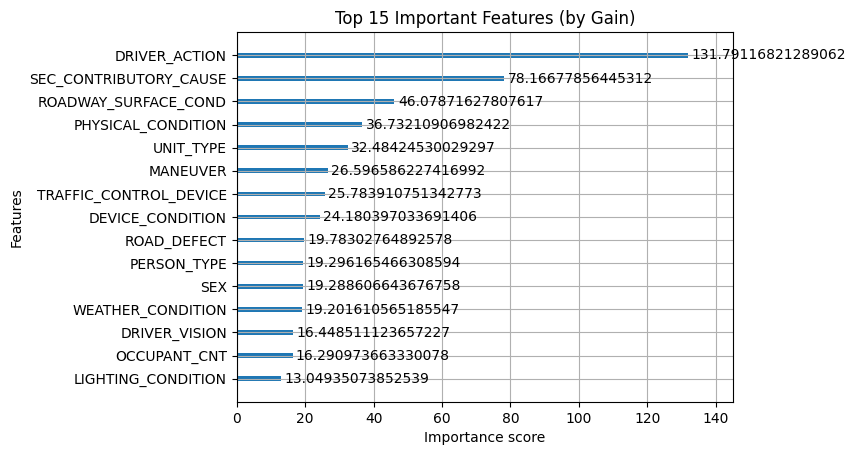

In [141]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(best_model, max_num_features=15, importance_type='gain')
plt.title('Top 15 Important Features (by Gain)')
plt.show()

And as seen from the graph above, the most important feature was the `DRIVER_ACTION` feature!

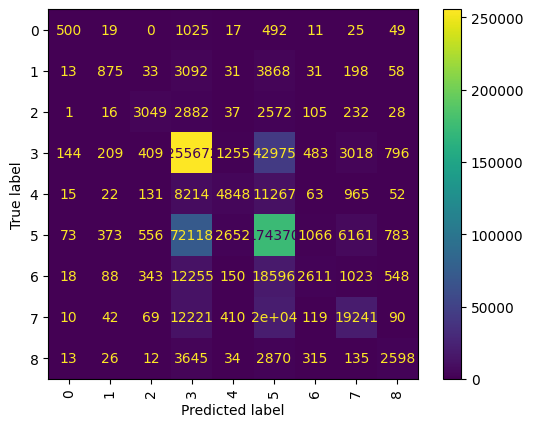

In [144]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test_enc, xticks_rotation='vertical')


From the metrics above, there is a significant imbalance in classes 3 and 5.

In [149]:
importance = best_model.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print(importance[:5])  # Top 5


[('DRIVER_ACTION', 131.79116821289062), ('SEC_CONTRIBUTORY_CAUSE', 78.16677856445312), ('ROADWAY_SURFACE_COND', 46.07871627807617), ('PHYSICAL_CONDITION', 36.73210906982422), ('UNIT_TYPE', 32.48424530029297)]


## CONCLUSION:


The leading cause of accidents in chicago is `Driver Action`. This means that the drivers contribute majorly to the accidents. This might be due to their distractions or even reckless driving. 

With this insight provided, the committee can now establish methods of overcoming the above mentioned issue!